# converting raw data into data needed for website

In [67]:
import pandas as pd

In [68]:
cols_to_load = ['essround', 'agea', 'gndr', 'cntry', 'netusoft', 'netuse', 'happy', 'health', 'aesfdrk', 'stflife', 'nwsppol', 'nwsptot', 'rdpol', 'rdtot', 'tvpol', 'tvtot', 'pray', 'rlgatnd', 'rlgdgr', 'sclact', 'sclmeet', 'inprdsc', 'hincfel', 'hinctnta', 'lrscale', 'imwbcnt', 'freehms', 'ccnthum', 'trstlgl', 'trstplc', 'trstplt']
raw_data = pd.read_csv('all_ess.csv', usecols=cols_to_load)

In [69]:
import re

# filter out vars with many missings (from milestone 1)
pattern_region = re.compile(r'^regio.*', flags=re.IGNORECASE)
region_columns = list(filter(pattern_region.match, raw_data.columns))
region_df = raw_data[region_columns]

pattern_parties = re.compile(r'^prtv.*', flags=re.IGNORECASE)
party_votes_columns = list(filter(pattern_parties.match, raw_data.columns))
parties_df = raw_data[party_votes_columns]

other_variables_col = list(filter(lambda col: not(pattern_parties.match(col) or pattern_region.match(col)), raw_data.columns))
raw_data_subset = raw_data[other_variables_col]

raw_data_subset.head()

,essround,cntry,netuse,netusoft,nwsppol,nwsptot,rdpol,rdtot,tvpol,tvtot,...,pray,rlgatnd,rlgdgr,sclact,sclmeet,gndr,agea,hincfel,hinctnta,ccnthum
0,1,AT,5.0,NaN,1.0,1.0,1.0,1.0,1.0,1.0,...,4,6,8,5,5,1,54,1.0,NaN,NaN
1,1,AT,6.0,NaN,2.0,2.0,1.0,4.0,2.0,3.0,...,7,6,5,5,6,1,50,3.0,NaN,NaN
2,1,AT,0.0,NaN,66.0,0.0,66.0,0.0,3.0,7.0,...,4,4,7,2,5,2,63,2.0,NaN,NaN
3,1,AT,4.0,NaN,2.0,2.0,1.0,1.0,1.0,1.0,...,4,4,7,3,5,1,44,1.0,NaN,NaN
4,1,AT,7.0,NaN,66.0,0.0,1.0,1.0,66.0,0.0,...,2,4,10,3,5,2,41,1.0,NaN,NaN


In [70]:
# assign year of response variable
raw_data_subset.loc[:,'essround_yr'] = raw_data_subset['essround']*2+2000

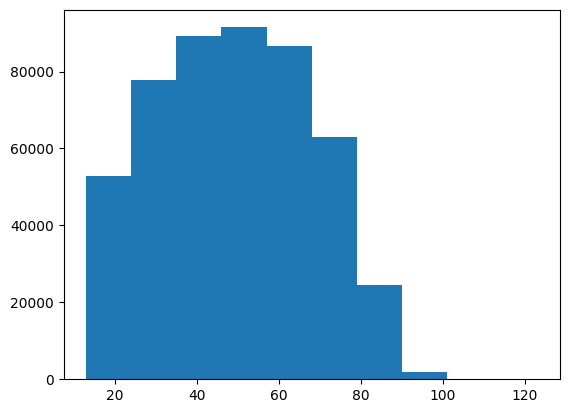

In [71]:
# see age distribution
import matplotlib.pyplot as plt
age_data = raw_data_subset[raw_data_subset['agea'] != 999]
plt.hist(age_data['agea'], bins=10)

# assign age group variable
bins = [0, 25, 39, 59, float('inf')]
labels = ['<25', '25-39', '40-59', '60+']
raw_data_subset.loc[:,'age_group'] = pd.cut(raw_data['agea'], bins=bins, labels=labels, right=False)
raw_data_subset.loc[:,'age_group'] = raw_data_subset['age_group'].astype('category')

In [72]:
# to create 'all' datasets, attach dataset to itself with 
raw_data_subset_all_ages = raw_data_subset.copy()
raw_data_subset_all_ages['age_group'] = "AGGREGATE"
raw_data_subset = pd.concat([raw_data_subset, raw_data_subset_all_ages])
raw_data_subset.age_group.value_counts()

age_group
AGGREGATE    490555
40-59        165259
60+          162921
25-39        103145
<25           59230
Name: count, dtype: int64

# Define Helper Functions
#### For converting raw data to data ready to be aggregated

In [73]:
# Helper function: prepare_for_aggregation()
### removes missing values, ensures increase implies improvement, and 0-1 normalizes ninned variables
def prepare_for_aggregation(data, vars, vars_improve_order, vars_ranges):

    # ignore missings, organize vars s.t. higher = better, normalize to be 1-6
    for var, order, range in zip(vars, vars_improve_order, vars_ranges):
        data[var] = data[var].where(data[var] <= range[1], other=float('nan'))
        if order == -1:
            data[var] *= -1
            range = sorted([val*-1 for val in range])
        data[var] = ((data[var] - range[0]) / (range[1] - range[0])) * (6-1) + 1
    return data

In [74]:
def extract_tuple_components(var_tuples):
    vars = [tuple[0] for tuple in var_tuples]
    vars_improve_order = [tuple[1] for tuple in var_tuples]
    vars_ranges = [tuple[2] for tuple in var_tuples]
    return vars, vars_improve_order, vars_ranges

In [75]:
cc_dict = {
    'AL': 'Albania', 
    'AT': 'Austria', 
    'BE': 'Belgium', 
    'BG': 'Bulgaria', 
    'CH': 'Switzerland', 
    'CY': 'Cyprus', 
    'CZ': 'Czechia', 
    'DE': 'Germany', 
    'DK': 'Denmark', 
    'EE': 'Estonia', 
    'ES': 'Spain', 
    'FI': 'Finland', 
    'FR': 'France', 
    'GB': 'United Kingdom', 
    'GE': 'Georgia', 
    'GR': 'Greece', 
    'HR': 'Croatia', 
    'HU': 'Hungary', 
    'IE': 'Ireland', 
    'IS': 'Iceland', 
    'IL': 'Israel', 
    'IT': 'Italy', 
    'LT': 'Lithuania', 
    'LU': 'Luxembourg', 
    'LV': 'Latvia', 
    'ME': 'Montenegro', 
    'MK': 'North Macedonia', 
    'NL': 'Netherlands', 
    'NO': 'Norway', 
    'PL': 'Poland', 
    'PT': 'Portugal',
    'RO': 'Romania', 
    'RS': 'Serbia', 
    'RU': 'Russian Federation', 
    'SE': 'Sweden', 
    'SI': 'Slovenia', 
    'SK': 'Slovakia', 
    'TR': 'Turkey', 
    'UA': 'Ukraine', 
    'XK': 'Kosovo'
}

# Define Variable Sets
#### May need to alter to create interesting story

In [76]:
# tuple structure: (var_name, missing_cutoff, improve_order, range)
## missing_cutoff: value above which variable should be considered missing for our purposes
## improve_order: 1 if higher is better, -1 if lower is better
## range: range variable can take
### details accessible via codebook: (https://github.com/com-480-data-visualization/ChartToppers/blob/master/all_variables_codebook.html)
var_sets = {}

# wellbeing
## happy: how happy are you
## health: how healthy are you
## aesfdrk: how concern about safety after dark
## stflife: how satisifed with life
var_sets['wellbeing'] = [('happy', 1, [1, 10]), ('health', -1, [1, 5]), ('aesfdrk', -1, [1,4]), ('stflife', 1, [1,10])]

# media consumption
## newsppol: how much political newspaper reading do you do
## newsptot: how much newspaper reading do you do
## rdpol: how much political radio listening do you do
## rdtot: how much radio listening do you do
## tvpol: how much political tv watching do you do
## tvtot: how much tv watching do you do
var_sets['media'] = [('nwsppol', 1, [0, 7]), ('nwsptot', 1, [0, 7]), ('rdpol', 1, [0,7]), ('rdtot', 1, [0, 7]), ('tvpol', 1, [0,7]), ('tvtot', 1, [0,7])] 

# internet usage
## netuse: personal internet use, how often
## netuseoft: internet use, how often
var_sets['internet'] = [('netuse', 1, [0, 7]), ('netusoft', 1, [1, 5])]

# religious activity
## pray: how often do you pray
## rlgatnd: how often do you attend religious services
## rlgdgr: how religious are you
var_sets['relig'] = [('pray', -1, [1, 7]), ('rlgatnd', -1, [1, 7]), ('rlgdgr', 1, [0, 10])]

# social activity
## sclact: how often do you take part in social activities compared to others of the same age
## sclmeet: how often do you socially meet with friends, relatives, or colleagues
## inprdsc: how many people to discuss intimate and personal matters
var_sets['social'] = [('sclact', 1, [1,5]), ('sclmeet', 1, [1,7]), ('inprdsc', 1, [0,6])]

# financial stability
## hincfel: feeling about household's income
## hinctnta: household's total net income, all sources (deciles)
var_sets['finstab'] = [('hincfel', -1, [1,4]), ('hinctnta', 1, [1,10])]

# conservatism (low = liberal, high = conservative)
## lrscale: placement of left-right scale
## imwbcnt: immigrants make country worse or better place to live
## freehms: gays and lesbians should live as they wish
## ccnthum: climate change caused by natural processes, human activity, or both
var_sets['conservatism'] = [('lrscale', 1, [0, 10]), ('imwbcnt', -1, [0,10]), ('freehms', 1, [1,5]), ('ccnthum', -1, [1,5])]

# trust
## trstlgl: trust in the legal system
## trstplc: trust in the police
## trstprl: trust in the country's parliament
var_sets['trust'] = [('trstlgl', 1, [0, 10]), ('trstplc', 1, [0, 10]), ('trstplt', 1, [0,10])]

# Validate Variable Sets

### Intra-bucket data availibility

In [107]:
def bucket_data_availability(data, var_set):
    vars, vars_improve_order, vars_ranges = extract_tuple_components(var_set)
    temp = data[data['agea'] != 999][vars + ['essround_yr']]
    data = prepare_for_aggregation(temp, vars, vars_improve_order, vars_ranges)

    for var in vars:
        unique_years = sorted(data.loc[data[var].notna(), 'essround_yr'].unique())
        print(var, unique_years)

for var_set in var_sets.keys():
    print(var_set)
    bucket_data_availability(raw_data_subset, var_sets[var_set])
    print("\n")

wellbeing
happy [2002, 2004, 2006, 2008, 2010, 2012, 2014, 2016, 2018, 2020]
health [2002, 2004, 2006, 2008, 2010, 2012, 2014, 2016, 2018, 2020]
aesfdrk [2002, 2004, 2006, 2008, 2010, 2012, 2014, 2016, 2018, 2020]
stflife [2002, 2004, 2006, 2008, 2010, 2012, 2014, 2016, 2018, 2020]


media
nwsppol [2002, 2004, 2006, 2008, 2010]
nwsptot [2002, 2004, 2006, 2008, 2010]
rdpol [2002, 2004, 2006, 2008, 2010]
rdtot [2002, 2004, 2006, 2008, 2010]
tvpol [2002, 2004, 2006, 2008, 2010, 2012, 2014]
tvtot [2002, 2004, 2006, 2008, 2010, 2012, 2014]


internet
netuse [2002, 2004, 2006, 2008, 2010]
netusoft [2016, 2018, 2020]


relig
pray [2002, 2004, 2006, 2008, 2010, 2012, 2014, 2016, 2018, 2020]
rlgatnd [2002, 2004, 2006, 2008, 2010, 2012, 2014, 2016, 2018, 2020]
rlgdgr [2002, 2004, 2006, 2008, 2010, 2012, 2014, 2016, 2018, 2020]


social
sclact [2002, 2004, 2006, 2008, 2010, 2012, 2014, 2016, 2018, 2020]
sclmeet [2002, 2004, 2006, 2008, 2010, 2012, 2014, 2016, 2018, 2020]
inprdsc [2012, 2014, 2016

### Intra-bucket correlations

In [109]:
def corr_matrix_all_respondents(data, var_set):
    vars, vars_improve_order, vars_ranges = extract_tuple_components(var_set)
    temp = data[data['agea'] != 999][vars + ['essround_yr', 'age_group']]
    data = prepare_for_aggregation(temp, vars, vars_improve_order, vars_ranges)
    data = data[data['age_group'] == 'AGGREGATE']
    data = data[data['essround_yr'] == 2020]
    print(data[vars].corr())

for var_set in var_sets.keys():
    print(var_set)
    corr_matrix_all_respondents(raw_data_subset, var_sets[var_set])
    print("\n")


wellbeing
            happy    health   aesfdrk   stflife
happy    1.000000  0.317124  0.197343  0.673638
health   0.317124  1.000000  0.193297  0.292237
aesfdrk  0.197343  0.193297  1.000000  0.191905
stflife  0.673638  0.292237  0.191905  1.000000


media
         nwsppol  nwsptot  rdpol  rdtot  tvpol  tvtot
nwsppol      NaN      NaN    NaN    NaN    NaN    NaN
nwsptot      NaN      NaN    NaN    NaN    NaN    NaN
rdpol        NaN      NaN    NaN    NaN    NaN    NaN
rdtot        NaN      NaN    NaN    NaN    NaN    NaN
tvpol        NaN      NaN    NaN    NaN    NaN    NaN
tvtot        NaN      NaN    NaN    NaN    NaN    NaN


internet
          netuse  netusoft
netuse       NaN       NaN
netusoft     NaN       1.0


relig
             pray   rlgatnd    rlgdgr
pray     1.000000  0.641186  0.689572
rlgatnd  0.641186  1.000000  0.619367
rlgdgr   0.689572  0.619367  1.000000


social
           sclact   sclmeet   inprdsc
sclact   1.000000  0.402416  0.252731
sclmeet  0.402416  1.000000

# Define Graph Data Functions

### Fig 1: Bar Chart


In [77]:
def bar_age_yr(data, var_tuples):

    # pull current buckets var info
    vars, vars_improve_order, vars_ranges = extract_tuple_components(var_tuples)

    # subset data to obs not missing agea
    temp = data[data['agea'] != 999][vars + ['essround_yr', 'age_group']]

    # prepare binned variables for aggregation
    prepare_for_aggregation(temp, vars, vars_improve_order, vars_ranges)

    # average in-group constituent var averages
    temp = temp.groupby(['essround_yr', 'age_group'], observed = True)[vars].mean().reset_index()
    temp['average'] = temp[vars].mean(axis=1)
    temp = temp.sort_values(by=['age_group', 'essround_yr'])
    return temp[['essround_yr', 'age_group', 'average']].round(2)


### Fig 2: Choropleth

In [78]:
def get_choropleth_color(m_minus_w):
    if -1.4 <= m_minus_w < -1.2: return 14
    elif -1.2 <= m_minus_w < -1.0: return 13
    elif -1.0 <= m_minus_w < -0.8: return 12
    elif -0.8 <= m_minus_w < -0.6: return 11
    elif -0.6 <= m_minus_w < -0.4: return 10
    elif -0.4 <= m_minus_w < -0.2: return 9
    elif -0.2 <= m_minus_w < 0.0: return 8
    elif 0.0 <= m_minus_w < 0.2: return 7
    elif 0.2 <= m_minus_w < 0.4: return 6
    elif 0.4 <= m_minus_w < 0.6: return 5
    elif 0.6 <= m_minus_w < 0.8: return 4
    elif 0.8 <= m_minus_w < 1.0: return 3
    elif 1.0 <= m_minus_w < 1.2: return 2
    elif 1.2 <= m_minus_w <= 1.4: return 1
    else: return 0

def choropleth_gend_cntry_age_yr(data, var_tuples):

    # pull current buckets var info
    vars, vars_improve_order, vars_ranges = extract_tuple_components(var_tuples)

    # subset data to obs not missing agea or gender
    temp = data[(data['agea'] != 999) & (data['gndr'] != 9)][vars + ['cntry', 'gndr', 'essround_yr', 'age_group']]

    # prepare binned variables for aggregation
    prepare_for_aggregation(temp, vars, vars_improve_order, vars_ranges)

    # average in-group constituent var averages, take differences
    temp = temp.groupby(['essround_yr', 'age_group', 'gndr', 'cntry'], observed = True)[vars].mean().reset_index()
    temp['average'] = temp[vars].mean(axis=1)
    temp = temp.pivot_table(index=['cntry', 'age_group', 'essround_yr'],
                    columns='gndr',
                    values= vars + ['average'],
                    aggfunc='mean',
                    observed = True)
    temp.columns = [f"{col[0]}_{col[1]}" for col in temp.columns]
    temp = temp.reset_index()
    temp['average_men'] = temp['average_1']
    temp['average_women'] = temp['average_2']
    temp['m_minus_w'] = temp['average_1'] - temp['average_2']
    temp['color'] = temp['m_minus_w'].apply(get_choropleth_color)

    temp = temp.sort_values(by=['cntry', 'age_group', 'essround_yr'])
    
    temp['country'] = temp['cntry'].map(cc_dict)
    return temp[['cntry', 'country', 'essround_yr', 'age_group', 'm_minus_w', 'color', 'average_men', 'average_women']].round(2)

### Fig 3: Ordinal Gender Country Year

In [79]:
def ordinal_gend_cntry_yr(data, var_tuples):

    # pull current buckets var info
    vars, vars_improve_order, vars_ranges = extract_tuple_components(var_tuples)

    # subset data to obs not missing agea or gender, only keep one instance per person (recall that each person is represented twice: once in their age group, once in 'aggregate' age group)
    temp = data[data['age_group'] == 'AGGREGATE']
    temp = temp[(temp['gndr'] != 9)][vars + ['cntry', 'gndr', 'essround_yr']]

    # double dataset, give duplicate instance country code "All" (to populate average lines by year)
    temp_all = temp.copy()
    temp_all['cntry'] = "AGGREGATE"
    temp = pd.concat([temp, temp_all])

    # prepare binned variables for aggregation
    prepare_for_aggregation(temp, vars, vars_improve_order, vars_ranges)

    # average in-group constituent var averages, take differences
    temp = temp.groupby(['essround_yr', 'gndr', 'cntry'], observed = True)[vars].mean().reset_index()
    temp['average'] = temp[vars].mean(axis=1)
    temp = temp.pivot_table(index=['cntry', 'essround_yr'],
                    columns='gndr',
                    values= vars + ['average'],
                    aggfunc='mean',
                    observed = True)
    temp.columns = [f"{col[0]}_{col[1]}" for col in temp.columns]
    temp = temp.reset_index()

    # create index for hover-over-country history. for each country, value for <25 in earliest year is 100 (for both women and men!)
    temp = temp.sort_values(by=['cntry', 'essround_yr'])
    temp['average_men'] = temp['average_1']
    temp['average_women'] = temp['average_2']
    temp['country'] = temp['cntry'].map(cc_dict)
    return temp[['cntry', 'country', 'essround_yr', 'average_men', 'average_women']].round(2)

# Create Data for All Buckets

In [80]:
bar_chart_dataframes = {}
choropleth_dataframes = {}
ordinal_cntry_list_dataframes = {}
for var_set in var_sets.keys():
    bar_chart_dataframes[var_set] = bar_age_yr(raw_data_subset, var_sets[var_set]).rename(columns={'average':var_set})
    choropleth_dataframes[var_set] = choropleth_gend_cntry_age_yr(raw_data_subset, var_sets[var_set]).rename(columns={'m_minus_w':var_set + '_m_minus_w','color':var_set + '_color', 'average_men':var_set + '_men','average_women':var_set + '_woman'})
    ordinal_cntry_list_dataframes[var_set] = ordinal_gend_cntry_yr(raw_data_subset, var_sets[var_set]).rename(columns={'average_men':var_set + '_men','average_women':var_set + '_woman'})
# data for pop-up text would be in choropleth function output

In [81]:
from functools import reduce

# Figure 1: Bar Chart data
f1_data = reduce(lambda left, right: pd.merge(left, right, on=['essround_yr', 'age_group'], how='outer'), bar_chart_dataframes.values())
f1_data.to_csv('figure_1_bar.csv', index=False)

# Figure 2: Choropleth data
f2_data = reduce(lambda left, right: pd.merge(left, right, on=['essround_yr', 'cntry', 'country', 'age_group'], how='outer'), choropleth_dataframes.values())
f2_data.to_csv('figure_2_choropleth.csv', index=False) 

# Figure 3: Ordinal Country List data
f3_data = reduce(lambda left, right: pd.merge(left, right, on=['essround_yr', 'cntry', 'country'], how='outer'), ordinal_cntry_list_dataframes.values())
f3_data.to_csv('figure_3_ordinal.csv', index=False)

# Explore Data - M minus W difference magnitudes

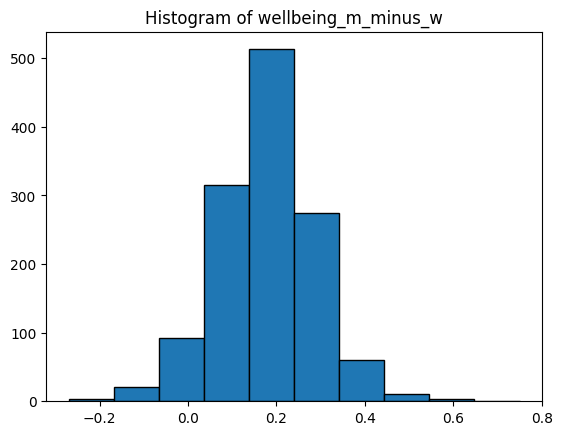

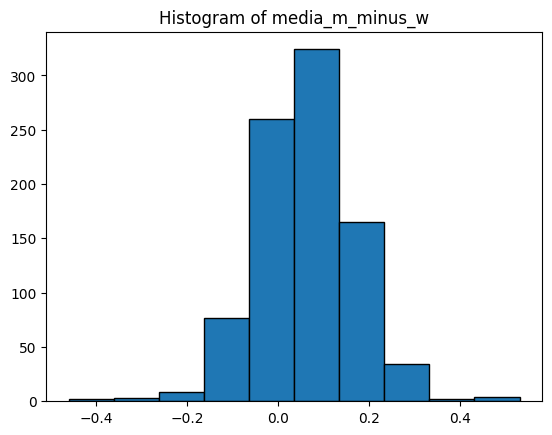

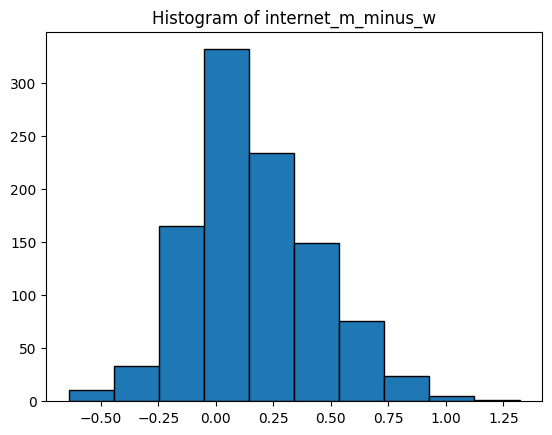

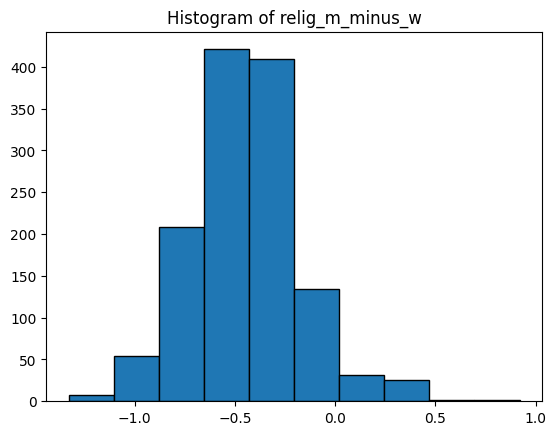

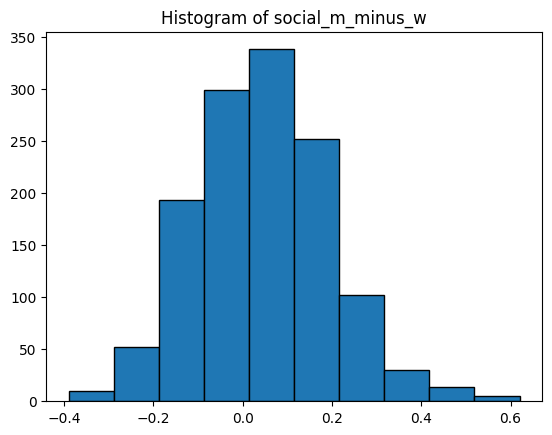

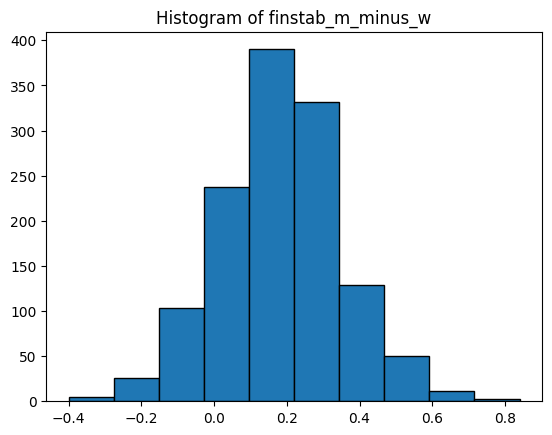

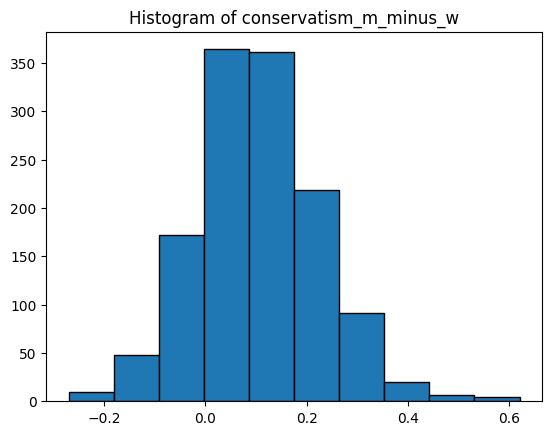

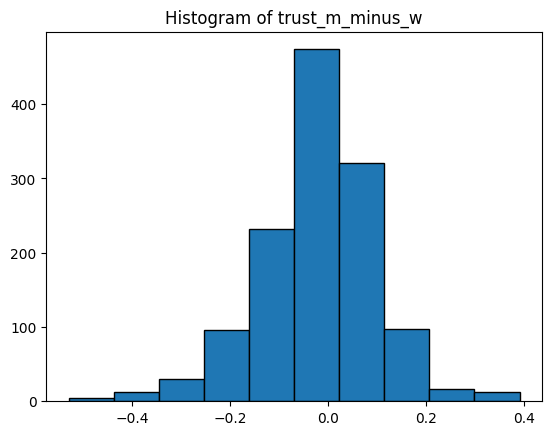

In [82]:
import matplotlib.pyplot as plt
for var_set in var_sets.keys():
    plt.hist(f2_data[var_set + '_m_minus_w'], bins=10, edgecolor='black')
    plt.title('Histogram of ' + var_set + '_m_minus_w')
    plt.show()

In [83]:
import matplotlib.pyplot as plt
for var_set in var_sets.keys():
    print(f2_data[var_set + '_m_minus_w'].agg('min'), f2_data[var_set + '_m_minus_w'].agg('max'))

-0.27 0.75
-0.46 0.53
-0.64 1.32
-1.33 0.92
-0.39 0.62
-0.4 0.84
-0.27 0.62
-0.53 0.39
